# Imports

In [1]:
import pandas as pd
import numpy as np
import sys, math, os, json, re, random
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

from reticulum import AdaptiveBayesianReticulum
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from tqdm import tqdm

from functions import *

# jupyter magic to display plots directly in the notebook
%matplotlib inline

# use vector graphics format for nicer plots
%config Inline.Backend.figure_format = 'svg'

%config Completer.use_jedi = False

%load_ext autoreload
%autoreload 2

In [2]:
DATA = 'RfqData.xlsx'

In [3]:
sheets = pd.ExcelFile(DATA).sheet_names
sheets

['Overview', 'Training RFQs', 'OOS RFQs', 'Competition RFQs']

In [4]:
training = pd.read_excel(DATA, sheet_name=sheets[1])
test = pd.read_excel(DATA, sheet_name=sheets[2])
competition = pd.read_excel(DATA, sheet_name=sheets[3])

In [5]:
training.head()

,Time,Bond,Side,Notional,N_group,Counterparty,MidPrice,QuotedPrice,Delta,Competitors,Profit,Status,Adjusted profit,Traded,NextMidPrice
0,25000.0,Bond_2,Offer,10000000.0,big,Ctpy_0,124.01,124.25,0.24,1.0,-0.01,0.0,0.00,MISSED,124.24
1,25001.0,Bond_0,Bid,1000.0,small,Ctpy_1,98.07,98.06,0.01,1.0,0.02,1.0,0.02,DONE,98.08
2,25002.0,Bond_1,Offer,1000.0,small,Ctpy_1,170.30,170.40,0.10,1.0,0.24,0.0,0.00,MISSED,170.64
3,25003.0,Bond_0,Bid,20000.0,big,Ctpy_0,98.00,97.98,0.02,4.0,-0.04,1.0,-0.04,DONE,97.94
4,25004.0,Bond_1,Offer,1000.0,small,Ctpy_3,171.12,171.16,0.04,2.0,0.30,1.0,0.30,DONE,171.46


In [6]:
training = training.dropna()
test = test.dropna()

In [7]:
test = test.drop(columns='N_group')

In [8]:
training = training[test.columns]

In [9]:
target_mapping = {'MISSED': 0, 'DONE': 1}

In [10]:
def add_features(df):
    df['Notional_cuts'] = pd.cut(df['Notional'], [0, 100000, 1000000, 10000000, 50000000], labels=[0, 1, 2, 3], include_lowest=True, right=True)
    df['Traded'] = df['Traded'].map(target_mapping)
    
    return df

### Trade Classification

In [11]:
def add_features_classifier(df):
    df['quote_diff'] = (df['QuotedPrice'] - df['MidPrice'])
    df['Traded'] = df['Traded'].map(target_mapping)
    # df['Competitors'] = df['Competitors'].apply(lambda x: str(x))
    df['Notional_cuts'] = pd.cut(df['Notional'], [0, 100000, 1000000, 10000000, 50000000], labels=[0, 1, 2, 3], include_lowest=True, right=True)
    
    cols = ['Side']
    one_hot_encode = pd.get_dummies(df[cols])
    df = df.join(one_hot_encode)
    
    cols_to_drop = ['Bond', 'Side', 'Counterparty', 'Time'] + ['Notional', 'QuotedPrice', 'MidPrice', 'NextMidPrice']
    
    return df.drop(columns=cols_to_drop)

In [12]:
def prep_data_classifier(train, test, y_value): # extract input and target
    X_train = train.drop(columns=[y_value]).values  
    y_train = train[[y_value]].values.ravel()
    
    X_test = test.drop(columns=[y_value]).values
    y_test = test[[y_value]].values.ravel()
    
    return X_train, y_train, X_test, y_test

In [13]:
training_classifier = add_features_classifier(training.copy())
test_classifier = add_features_classifier(test.copy())

In [14]:
X_train_c, y_train_c, X_test_c, y_test_c = prep_data_classifier(training_classifier, test_classifier, 'Traded')

In [15]:
# train model
ABRmodel = AdaptiveBayesianReticulum(
    prior=(1, 1),
    pruning_factor=1.01,
    n_iter=100,
    learning_rate_init=0.05,
    n_gradient_descent_steps=1,
    initial_relative_stiffness=20)

t0 = dt.datetime.utcnow()
ABRmodel.fit(X_train_c, y_train_c, verbose=False)
t1 = dt.datetime.utcnow()

# print('Model:')
# print(ABRmodel)
print(f'Training took {t1-t0}')

# evaluate performance
log_loss_train = log_loss(y_train_c, ABRmodel.predict_proba(X_train_c))
log_loss_test = log_loss(y_test_c, ABRmodel.predict_proba(X_test_c))
accuracy_train = accuracy_score(y_train_c, ABRmodel.predict(X_train_c))
accuracy_test = accuracy_score(y_test_c, ABRmodel.predict(X_test_c))

info_train = f'Train: Log-loss = {log_loss_train}, accuracy = {100*accuracy_train:.4f} %'
info_test = f'Test: Log-loss = {log_loss_test}, accuracy = {100*accuracy_test:.4f} %'
print(f'Depth:  {ABRmodel.get_depth()}')
print(f'Leaves: {ABRmodel.get_n_leaves()}')
print(info_train)
print(info_test)
print(f'Feature importance: {ABRmodel.feature_importance()}')

Training took 0:00:00.359385
Depth:  11
Leaves: 55
Train: Log-loss = 0.40480633021790313, accuracy = 82.7200 %
Test: Log-loss = 0.4197856003451943, accuracy = 82.9000 %
Feature importance: [0.05985697 0.74400737 0.03922869 0.08784186 0.06906511]


### Mid Price Prediction for Counterparty 0

In [16]:
def add_features_rf(df):
    df['Notional_cuts'] = pd.cut(df['Notional'], [0, 100000, 1000000, 10000000, 50000000], labels=[0, 1, 2, 3], include_lowest=True, right=True)
    df['NextMidP'] = df['NextMidPrice']/df['MidPrice']
    df['Traded'] = df['Traded'].map(target_mapping)
    
    cols = ['Side']
    one_hot_encode = pd.get_dummies(df[cols])
    df = df.join(one_hot_encode)
    
    cols3 = ['Bond']
    one_hot_encode3 = pd.get_dummies(df[cols3])
    df = df.join(one_hot_encode3)
    
    cols_to_drop = ['Bond', 'Side', 'Time', 'QuotedPrice'] + ['NextMidPrice', 'Notional', 'Traded']
    
    return df.drop(columns=cols_to_drop)

In [17]:
def random_forest_hyperparameters(X_train, y_train, X_test, y_test):
    estimators = np.arange(5, 51, 1)
    train_rmses = []
    test_rmses = []
    train_sign_errors = []
    test_sign_errors = []
    
    for e in tqdm(estimators):
        regressor, preds, metrics = random_forest(X_train, y_train, X_test, y_test, e)
        train_rmses.append(metrics[0])
        test_rmses.append(metrics[1])
        train_sign_errors.append(metrics[2])
        test_sign_errors.append(metrics[3])
        
    plt.plot(estimators, train_rmses)
    plt.title('Train RMSE')
    plt.show()
    plt.plot(estimators, test_rmses)
    plt.title('Test RMSE')
    plt.show()
    
    plt.plot(estimators, train_sign_errors, label='Train')
    plt.plot(estimators, test_sign_errors, label='Test')
    plt.title('Sign Errors')
    plt.legend()
    plt.show()
    
    return regressor, [train_rmses, test_rmses, train_sign_errors, test_sign_errors]

In [18]:
def random_forest(X_train, y_train, X_test, y_test, e):
    regressor = RandomForestRegressor(n_estimators=e, random_state=0)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    train_rmse = (np.sqrt(metrics.mean_squared_error(regressor.predict(X_train), y_train)))
    test_rmse = (np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    train_se = (np.sign(regressor.predict(X_train) -np.ones(len(X_train))) != np.sign(y_train - np.ones(len(X_train)))).sum()/len(X_train)
    test_se = (np.sign(y_pred - np.ones(len(y_pred))) != np.sign(y_test - np.ones(len(y_pred)))).sum()/len(y_test)
    return regressor, y_pred, [train_rmse, test_rmse, train_se, test_se]

In [19]:
def get_train_test(df_train, df_test):
    X_train = df_train.drop(columns=['NextMidP', 'MidPrice', 'Counterparty']).values
    y_train = df_train[['NextMidP']].values.ravel()
    X_test = df_test.drop(columns=['NextMidP', 'MidPrice', 'Counterparty']).values
    y_test = df_test[['NextMidP']].values.ravel()
    
    return X_train, y_train, X_test, y_test

In [20]:
counterparty_models = {}
counterparty_ecdfs = {}

In [21]:
def random_forest_for_counterparty(training, test, counterparty):
    train = add_features_rf(training.query("Counterparty == @counterparty").copy())
    test = add_features_rf(test.query("Counterparty == @counterparty").copy())
    
    train_midp = train[['MidPrice']].values.ravel()
    
    X_train, y_train, X_test, y_test = get_train_test(train, test)
    
    reg, y_pred, error_metrics = random_forest(X_train, y_train, X_test, y_test, 40)
    print(counterparty)
    print("Train RMSE =", error_metrics[0])
    print("Test RMSE =", error_metrics[1])
    print("Train sign error =", error_metrics[2])
    print("Test sign error =", error_metrics[3])
    
    train_preds = reg.predict(X_train)
    next_midp_pred = train_preds * train_midp
    next_midp_true = y_train * train_midp
    errors = next_midp_pred - next_midp_true
    print('Train RMSE in $ =', np.sqrt(np.mean(np.power(errors, 2))))
    ecdf = ECDF(errors)
    
    counterparty_models[counterparty] = reg
    counterparty_ecdfs[counterparty] = ecdf
    
    #counterparty_models[counterparty] = {'model':reg, 'ecdf':ecdf}

In [22]:
def base_pred_errors_for_counterparty(training, counterparty):
    df = training.query("Counterparty == @counterparty").copy()
    train_midp = df[['MidPrice']].values.ravel()
    train_preds = train_midp
    next_midp_pred = train_midp
    next_midp_true = df[['NextMidPrice']].values.ravel()
    errors = next_midp_pred - next_midp_true
    print('RMSE in $ =', np.sqrt(np.mean(np.power(errors, 2))))
    ecdf = ECDF(errors)
    #plt.hist(errors, bins=50);
    
    counterparty_ecdfs[counterparty] = ecdf

In [23]:
def get_bond_stdevs(training):
    trial_training = add_features(training.copy(deep=True))
    trial_training['MidPrice_diff'] = trial_training['NextMidPrice'] - trial_training['MidPrice']
    bond_stds = trial_training.groupby(['Bond', 'Notional_cuts'])['MidPrice_diff'].std().reset_index()
    return bond_stds

In [24]:
random_forest_for_counterparty(training, test, "Ctpy_0")

Ctpy_0
Train RMSE = 0.0006045980594882525
Test RMSE = 0.000634335878293191
Train sign error = 0.08783783783783784
Test sign error = 0.10638297872340426
Train RMSE in $ = 0.06563054833502295


In [25]:
random_forest_for_counterparty(training, test, "Ctpy_2")

Ctpy_2
Train RMSE = 0.0005465394985861825
Test RMSE = 0.0007341603395218657
Train sign error = 0.09829059829059829
Test sign error = 0.22916666666666666
Train RMSE in $ = 0.061621656194033474


In [26]:
base_pred_errors_for_counterparty(training, "Ctpy_1")

RMSE in $ = 0.14059849171219221


In [27]:
base_pred_errors_for_counterparty(training, "Ctpy_3")

RMSE in $ = 0.13545845262265285


In [28]:
bond_stds = get_bond_stdevs(training)

In [29]:
def get_bond(trade):
    if trade.loc['Bond_Bond_0'] == 1:
        return 'Bond_0'
    if trade.loc['Bond_Bond_1'] == 1:
        return 'Bond_1'
    if trade.loc['Bond_Bond_2'] == 1:
        return 'Bond_2'

In [30]:
def get_side(trade):
    if trade.loc['Side_Bid'] == 1:
        return 'Bid'
    if trade.loc['Side_Offer'] == 1:
        return 'Offer'

In [31]:
def delta_range(curr_mid, next_mid_pred, sd, notional, side):
    higher = next_mid_pred > curr_mid
    equal = next_mid_pred == curr_mid
    # sd = sd*(notional+1)
    if side == "Offer":
        if higher:
            return np.arange(next_mid_pred, next_mid_pred + sd+0.001, 0.01)
        elif equal:
            return np.arange(next_mid_pred, next_mid_pred + sd+0.001, 0.01)
        else:
            return np.arange(curr_mid, next_mid_pred+0.001, 0.01)
        
    if side == "Bid":
        if higher:
            return np.arange(curr_mid, next_mid_pred)
        elif equal:
            return np.arange(next_mid_pred - sd, next_mid_pred+0.001, 0.01)
        else:
            return np.arange(next_mid_pred - sd, next_mid_pred+0.001, 0.01)

In [32]:
def profit_scenario(side,verbose=False):
    if side == "Offer":
        if verbose:print('Profit if Quote Price is above Next Mid Price')
    elif side == "Bid":
        if verbose:print('Profit if Quote Price is below Next Mid Price')

In [33]:
def get_quote_price(trade, identifier, counterparty_lambdas,verbose=False):
    midp = np.round(trade['MidPrice'], 2)
    next_midp_true = np.round(midp*trade['NextMidP'], 2)
    trade_rf = trade.drop(index=['NextMidP', 'MidPrice']).values.reshape(1, -1)
    
    trade_bond = get_bond(trade)
    trade_notional = int(trade['Notional_cuts'])
    trade_side = get_side(trade)
    
    if verbose: print(f"Trade is for {trade_side} side")
    profit_scenario(trade_side,verbose)
    
    if identifier in counterparty_models.keys():
        if verbose: print('Using model to generate midprice forecast')
        pred = counterparty_models[identifier].predict(trade_rf)[0]
        next_midp_pred = np.round(midp*pred, 2)
    else:
        if verbose: print('Current midprice is estimate of next midprice')
        next_midp_pred = np.round(midp, 2)
    
    if verbose: print(f"Current mid price is: {midp}")
    if verbose: print(f"Predicted next mid price is: {next_midp_pred} and actual next mid price is: {next_midp_true}")
    
    
        
    sd = bond_stds.query("Bond == @trade_bond and Notional_cuts == @trade_notional").iloc[0]['MidPrice_diff']
    
    deltas = delta_range(midp, next_midp_pred, sd, trade_notional, trade_side)
    
    deltas_df = pd.DataFrame(deltas, columns=['Quotes'])
    deltas_df['Competitors'] = trade['Competitors']
    deltas_df['Notional_cuts'] = trade['Notional_cuts']
    deltas_df['Side_Bid'] = trade['Side_Bid']
    deltas_df['Side_Offer'] = trade['Side_Offer']
    deltas_df['quote_diff'] = (deltas_df['Quotes'] - midp)
    
    if trade_side == 'Offer':
        deltas_df['p_neg'] = counterparty_ecdfs[identifier](next_midp_pred - deltas_df['Quotes'])
    if trade_side == 'Bid':
        deltas_df['p_neg'] = 1 - counterparty_ecdfs[identifier](next_midp_pred - deltas_df['Quotes'])
    
    deltas_df['p_pos'] = 1 - deltas_df['p_neg']
    
    deltas_df['p_win'] = ABRmodel.predict_proba(deltas_df.drop(columns=['Quotes', 'p_neg', 'p_pos']).values)[:, 1]
    
    lambd = counterparty_lambdas[identifier]
    deltas_df['objective_func'] = deltas_df['p_win']*deltas_df['p_pos'] - lambd*(deltas_df['p_win']*deltas_df['p_neg'])
    
    if trade_side == "Offer":
        deltas_df = deltas_df[::-1].reset_index(drop=True)
    deltas_df['rate_of_change'] = (deltas_df['objective_func']/deltas_df['objective_func'].shift(-1)).fillna(0)
                                                                                    
    # find point where "utility starts diminishing
    best_quote = np.round(deltas_df.iloc[deltas_df['rate_of_change'].idxmax()-1]['Quotes'], 2)
    if verbose: print(f"Best Quote price is: {best_quote}")
    
    return deltas_df, (math.floor(best_quote*100)/100)

In [34]:
trial_test = test.copy(deep=True)
trial_test = add_features_rf(trial_test)
trial_trade0 = trial_test.loc[995, :]
trial_trade1 = trial_test.loc[996, :]
trial_trade2 = trial_test.loc[990, :]
trial_trade3 = trial_test.loc[997, :]

In [35]:
trial_trade3

Counterparty       Ctpy_3
MidPrice           110.49
Competitors           1.0
Notional_cuts           0
NextMidP         0.997918
Side_Bid                0
Side_Offer              1
Bond_Bond_0             0
Bond_Bond_1             0
Bond_Bond_2             1
Name: 997, dtype: object

In [36]:
test.loc[995, :]

Time            30995.0
Bond             Bond_0
Side              Offer
Notional        30000.0
Counterparty     Ctpy_0
MidPrice          83.01
QuotedPrice       83.04
Competitors         1.0
Traded           MISSED
NextMidPrice      83.06
Name: 995, dtype: object

In [37]:
counterparty_lambdas = {'Ctpy_0': 0, 'Ctpy_1': 0, 'Ctpy_2': 0, 'Ctpy_3': 0}

In [38]:
delta_df, best_q = get_quote_price(trial_trade0.drop(index='Counterparty'), 
                                   trial_trade0.loc['Counterparty'], counterparty_lambdas,True)

Trade is for Offer side
Profit if Quote Price is above Next Mid Price
Using model to generate midprice forecast
Current mid price is: 83.01
Predicted next mid price is: 83.04 and actual next mid price is: 83.06
Best Quote price is: 83.07


In [39]:
delta_df

,Quotes,Competitors,Notional_cuts,Side_Bid,Side_Offer,quote_diff,p_neg,p_pos,p_win,objective_func,rate_of_change
0,83.12,1.0,0,0,1,0.11,0.058880,0.941120,0.816848,0.768752,1.017598
1,83.11,1.0,0,0,1,0.10,0.075290,0.924710,0.816966,0.755457,1.022293
2,83.10,1.0,0,0,1,0.09,0.095560,0.904440,0.817061,0.738983,1.034150
3,83.09,1.0,0,0,1,0.08,0.125483,0.874517,0.817114,0.714580,1.055961
4,83.08,1.0,0,0,1,0.07,0.171815,0.828185,0.817101,0.676711,1.090360
5,83.07,1.0,0,0,1,0.06,0.240347,0.759653,0.816993,0.620631,1.135970
6,83.06,1.0,0,0,1,0.05,0.331081,0.668919,0.816757,0.546344,1.165278
7,83.05,1.0,0,0,1,0.04,0.425676,0.574324,0.816356,0.468853,1.129874
8,83.04,1.0,0,0,1,0.03,0.491313,0.508687,0.815748,0.414961,0.000000


In [40]:
delta_df1, best_q1 = get_quote_price(trial_trade1.drop(index='Counterparty'), 
                                   trial_trade1.loc['Counterparty'], counterparty_lambdas,True)

Trade is for Bid side
Profit if Quote Price is below Next Mid Price
Current midprice is estimate of next midprice
Current mid price is: 110.52
Predicted next mid price is: 110.52 and actual next mid price is: 110.49
Best Quote price is: 110.48


In [41]:
delta_df1

,Quotes,Competitors,Notional_cuts,Side_Bid,Side_Offer,quote_diff,p_neg,p_pos,p_win,objective_func,rate_of_change
0,110.390997,3.0,0,1,0,-0.129003,0.158985,0.841015,0.663528,0.558037,1.024961
1,110.400997,3.0,0,1,0,-0.119003,0.183033,0.816967,0.666424,0.544447,1.027135
2,110.410997,3.0,0,1,0,-0.109003,0.208417,0.791583,0.669625,0.530064,1.017079
3,110.420997,3.0,0,1,0,-0.099003,0.225785,0.774215,0.673150,0.521163,1.027988
4,110.430997,3.0,0,1,0,-0.089003,0.251169,0.748831,0.677020,0.506974,1.027707
5,110.440997,3.0,0,1,0,-0.079003,0.275885,0.724115,0.681253,0.493306,1.037294
6,110.450997,3.0,0,1,0,-0.069003,0.306613,0.693387,0.685865,0.475570,1.035663
7,110.460997,3.0,0,1,0,-0.059003,0.335337,0.664663,0.690866,0.459193,1.042539
8,110.470997,3.0,0,1,0,-0.049003,0.367401,0.632599,0.696265,0.440457,1.041219
9,110.480997,3.0,0,1,0,-0.039003,0.397462,0.602538,0.702063,0.423020,1.059377


In [42]:
delta_df2, best_q2 = get_quote_price(trial_trade2.drop(index='Counterparty'), 
                                   trial_trade2.loc['Counterparty'], counterparty_lambdas,True)

Trade is for Bid side
Profit if Quote Price is below Next Mid Price
Using model to generate midprice forecast
Current mid price is: 110.56
Predicted next mid price is: 110.42 and actual next mid price is: 110.4
Best Quote price is: 110.39


In [43]:
delta_df2

,Quotes,Competitors,Notional_cuts,Side_Bid,Side_Offer,quote_diff,p_neg,p_pos,p_win,objective_func,rate_of_change
0,110.301908,1.0,1,1,0,-0.258092,0.029915,0.970085,0.022021,0.021363,1.004425
1,110.311908,1.0,1,1,0,-0.248092,0.034188,0.965812,0.022021,0.021268,1.008929
2,110.321908,1.0,1,1,0,-0.238092,0.042735,0.957265,0.022021,0.021080,1.013575
3,110.331908,1.0,1,1,0,-0.228092,0.055556,0.944444,0.022021,0.020798,1.009132
4,110.341908,1.0,1,1,0,-0.218092,0.064103,0.935897,0.022021,0.020610,1.009217
5,110.351908,1.0,1,1,0,-0.208092,0.072650,0.927350,0.022021,0.020421,1.033333
6,110.361908,1.0,1,1,0,-0.198092,0.102564,0.897436,0.022021,0.019763,1.024390
7,110.371908,1.0,1,1,0,-0.188092,0.123932,0.876068,0.022021,0.019292,1.067708
8,110.381908,1.0,1,1,0,-0.178092,0.179487,0.820513,0.022021,0.018069,1.084746
9,110.391908,1.0,1,1,0,-0.168092,0.243590,0.756410,0.022021,0.016657,1.134615


In [44]:
delta_df3, best_q3 = get_quote_price(trial_trade3.drop(index='Counterparty'), 
                                   trial_trade3.loc['Counterparty'], counterparty_lambdas,True)

Trade is for Offer side
Profit if Quote Price is above Next Mid Price
Current midprice is estimate of next midprice
Current mid price is: 110.49
Predicted next mid price is: 110.49 and actual next mid price is: 110.26
Best Quote price is: 110.51


In [45]:
delta_df3

,Quotes,Competitors,Notional_cuts,Side_Bid,Side_Offer,quote_diff,p_neg,p_pos,p_win,objective_func,rate_of_change
0,110.62,1.0,0,0,1,0.13,0.127183,0.872817,0.816597,0.712740,1.015479
1,110.61,1.0,0,0,1,0.12,0.140618,0.859382,0.816721,0.701875,1.016800
2,110.60,1.0,0,0,1,0.11,0.154948,0.845052,0.816848,0.690278,1.022616
3,110.59,1.0,0,0,1,0.10,0.173757,0.826243,0.816966,0.675012,1.027736
4,110.58,1.0,0,0,1,0.09,0.196149,0.803851,0.817061,0.656796,1.029177
5,110.57,1.0,0,0,1,0.08,0.218988,0.781012,0.817114,0.638176,1.033805
6,110.56,1.0,0,0,1,0.07,0.244514,0.755486,0.817101,0.617308,1.043428
7,110.55,1.0,0,0,1,0.06,0.275862,0.724138,0.816993,0.591615,1.040841
8,110.54,1.0,0,0,1,0.05,0.304075,0.695925,0.816757,0.568401,1.053363
9,110.53,1.0,0,0,1,0.04,0.339006,0.660994,0.816356,0.539607,1.043150


### Testing performance on all test data

In [46]:
bestquotes=[]
for idx,row in trial_test.iterrows():
    delta_df3, best_q3 = get_quote_price(row.drop(index='Counterparty'), 
                                   row.loc['Counterparty'], counterparty_lambdas)
    bestquotes.append(best_q3)

In [47]:
pnl(bestquotes,test)

pos_pnl:577
better_price:651
traded_pos_pnl:347


#### Competition Quote

In [48]:
trial_test.columns

Index(['Counterparty', 'MidPrice', 'Competitors', 'Notional_cuts', 'NextMidP',
       'Side_Bid', 'Side_Offer', 'Bond_Bond_0', 'Bond_Bond_1', 'Bond_Bond_2'],
      dtype='object')

In [49]:
##just random numbers to make the function run but this shouldn't affect the result
competition['Traded'] = 1
competition['NextMidPrice'] = 100

In [50]:
competition_rf = add_features_rf(competition.copy())
competition_rf

,Counterparty,MidPrice,Competitors,Notional_cuts,NextMidP,Side_Bid,Side_Offer,Bond_Bond_0,Bond_Bond_1,Bond_Bond_2
0,Ctpy_0,82.55,3,0,1.211387,1,0,1,0,0
1,Ctpy_3,110.32,4,0,0.906454,1,0,0,0,1
2,Ctpy_0,126.83,2,1,0.788457,0,1,0,1,0
3,Ctpy_1,82.28,1,0,1.215362,1,0,1,0,0
4,Ctpy_1,109.99,2,0,0.909174,0,1,0,0,1


In [51]:
competition_rf.columns

Index(['Counterparty', 'MidPrice', 'Competitors', 'Notional_cuts', 'NextMidP',
       'Side_Bid', 'Side_Offer', 'Bond_Bond_0', 'Bond_Bond_1', 'Bond_Bond_2'],
      dtype='object')

In [52]:
final_quotes=[]
for idx,row in competition_rf.iterrows():
    delta_df3, best_q3 = get_quote_price(row.drop(index='Counterparty'), 
                                   row.loc['Counterparty'], counterparty_lambdas,True)
    final_quotes.append(best_q3)

Trade is for Bid side
Profit if Quote Price is below Next Mid Price
Using model to generate midprice forecast
Current mid price is: 82.55
Predicted next mid price is: 82.52 and actual next mid price is: 100.0
Best Quote price is: 82.49
Trade is for Bid side
Profit if Quote Price is below Next Mid Price
Current midprice is estimate of next midprice
Current mid price is: 110.32
Predicted next mid price is: 110.32 and actual next mid price is: 100.0
Best Quote price is: 110.3
Trade is for Offer side
Profit if Quote Price is above Next Mid Price
Using model to generate midprice forecast
Current mid price is: 126.83
Predicted next mid price is: 127.04 and actual next mid price is: 100.0
Best Quote price is: 127.07
Trade is for Bid side
Profit if Quote Price is below Next Mid Price
Current midprice is estimate of next midprice
Current mid price is: 82.28
Predicted next mid price is: 82.28 and actual next mid price is: 100.0
Best Quote price is: 82.24
Trade is for Offer side
Profit if Quote P

### 2b - Plot the probability of getting a fill as a function of the price (distance from mid) for the modal quantity, number of competitors, etc.

In [62]:
delta_df3

,Quotes,Competitors,Notional_cuts,Side_Bid,Side_Offer,quote_diff,p_neg,p_pos,p_win,objective_func,rate_of_change
0,110.12,2,0,0,1,0.13,0.124916,0.875084,0.837445,0.732834,1.019495
1,110.11,2,0,0,1,0.12,0.140949,0.859051,0.836762,0.718821,1.019169
2,110.10,2,0,0,1,0.11,0.156313,0.843687,0.835975,0.705302,1.027090
3,110.09,2,0,0,1,0.10,0.177689,0.822311,0.835084,0.686699,1.018575
4,110.08,2,0,0,1,0.09,0.191717,0.808283,0.834084,0.674176,1.034685
5,110.07,2,0,0,1,0.08,0.217769,0.782231,0.832971,0.651576,1.033245
6,110.06,2,0,0,1,0.07,0.241817,0.758183,0.831740,0.630611,1.041077
7,110.05,2,0,0,1,0.06,0.270541,0.729459,0.830382,0.605730,1.049873
8,110.04,2,0,0,1,0.05,0.303941,0.696059,0.828888,0.576955,1.056748
9,110.03,2,0,0,1,0.04,0.340013,0.659987,0.827247,0.545972,1.036813


Bond Bond_2
Side Offer
Notional 1000
MidPrice 109.99
Competitors 2
The probability of getting a fill as a function of the price


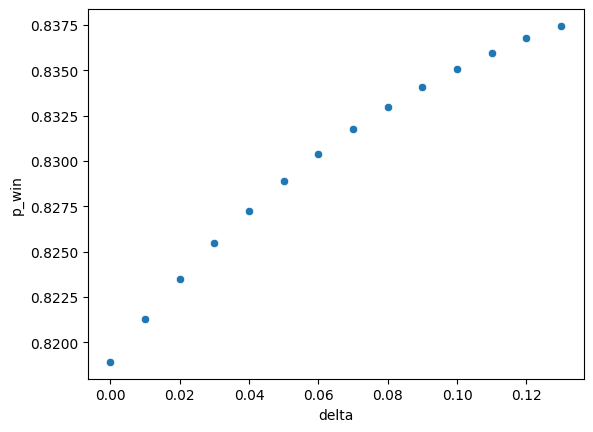

In [94]:
print(f"Bond {competition.iloc[-1]['Bond']}")
print(f"Side {competition.iloc[-1]['Side']}")
print(f"Notional {competition.iloc[-1]['Notional']}")
print(f"MidPrice {competition.iloc[-1]['MidPrice']}")
print(f"Competitors {competition.iloc[-1]['Competitors']}")

print("The probability of getting a fill as a function of the price")

delta_df3['delta'] = delta_df3['Quotes'] - competition.iloc[-1]['MidPrice']

sns.scatterplot(x='delta',y='p_win', data=delta_df3)
plt.show()

In [70]:
competition

,Time,Bond,Side,Notional,Counterparty,MidPrice,QuotedPrice,Competitors,Traded,NextMidPrice
0,31000,Bond_0,Bid,1000,Ctpy_0,82.55,NaN,3,1,100
1,31001,Bond_2,Bid,1000,Ctpy_3,110.32,NaN,4,1,100
2,31004,Bond_1,Offer,300000,Ctpy_0,126.83,NaN,2,1,100
3,31008,Bond_0,Bid,1000,Ctpy_1,82.28,NaN,1,1,100
4,31009,Bond_2,Offer,1000,Ctpy_1,109.99,NaN,2,1,100


### Random Analysis

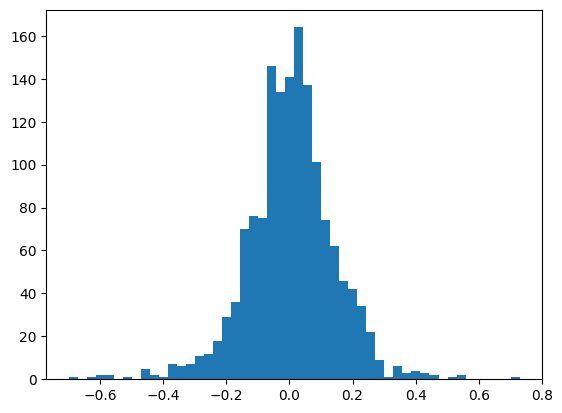

In [53]:
df_analysis = training.query("Counterparty == 'Ctpy_1'").copy()
df_analysis = add_features(df_analysis)
train_midp = df_analysis[['MidPrice']].values.ravel()
train_preds = train_midp
next_midp_pred = train_midp
next_midp_true = df_analysis[['NextMidPrice']].values.ravel()
errors = next_midp_pred - next_midp_true
plt.hist(errors, bins=50);

In [54]:
df_analysis = training.query("Counterparty == 'Ctpy_3'").copy()
df_analysis = add_features(df_analysis)

In [55]:
train_midp = df_analysis[['MidPrice']].values.ravel()
train_preds = train_midp
next_midp_pred = train_midp
next_midp_true = df_analysis[['NextMidPrice']].values.ravel()
errors = next_midp_pred - next_midp_true

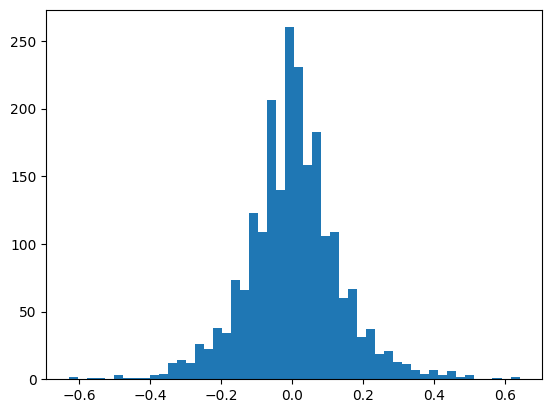

In [56]:
plt.hist(errors, bins=50);

In [57]:
side_dict = {'Offer':1, 'Bid':-1}
traded_dict = {'DONE':1, 'MISSED':np.nan}
target_mapping = {'MISSED': 0, 'DONE': 1}

In [58]:
df_analysis['side_tag'] = 1*(df_analysis['Side'] == 'Offer') + -1*(df_analysis['Side'] == 'Bid')
df_analysis['traded_tag'] = 1*(df_analysis['Traded'] == 1) + 0*(df_analysis['Traded'] == 0)
df_analysis.loc[df_analysis['traded_tag'] == 0,'traded_tag'] = np.nan
df_analysis['profit'] = (df_analysis['QuotedPrice'] - df_analysis['NextMidPrice'])*df_analysis['side_tag']*df_analysis['traded_tag']
df_analysis['profit'] = (df_analysis['QuotedPrice'] - df_analysis['NextMidPrice'])*df_analysis['side_tag']*df_analysis['traded_tag']

In [59]:
df_analysis.groupby(['Bond', 'Notional_cuts'])['profit'].describe().reset_index()

,Bond,Notional_cuts,count,mean,std,min,25%,50%,75%,max
0,Bond_0,0,585.0,0.012735,0.094789,-0.25,-0.050,0.00,0.0700,0.40
1,Bond_0,1,39.0,-0.006154,0.085613,-0.16,-0.055,-0.02,0.0500,0.18
2,Bond_0,2,117.0,0.011624,0.108238,-0.30,-0.060,0.01,0.0700,0.28
3,Bond_1,0,77.0,0.057532,0.239633,-0.54,-0.080,0.02,0.1900,0.73
4,Bond_1,1,7.0,-0.012857,0.276207,-0.51,-0.115,0.03,0.1450,0.33
5,Bond_1,2,13.0,0.163077,0.266814,-0.28,-0.020,0.19,0.2800,0.61
6,Bond_2,0,444.0,0.025676,0.144284,-0.45,-0.060,0.02,0.1200,0.53
7,Bond_2,1,17.0,-0.029412,0.147244,-0.27,-0.130,-0.04,0.0700,0.25
8,Bond_2,2,74.0,0.019054,0.139757,-0.27,-0.070,0.01,0.1075,0.30


In [60]:
df_analysis['MidP_diff'] = df_analysis['NextMidPrice']/df_analysis['MidPrice'] - 1
df_analysis['Quote_diff'] = df_analysis['QuotedPrice']/df_analysis['MidPrice'] - 1
df_analysis['Abs_MidP_diff'] = np.abs(df_analysis['NextMidPrice']/df_analysis['MidPrice'] - 1)
df_analysis['log_notional'] = np.log(df_analysis['Notional'])

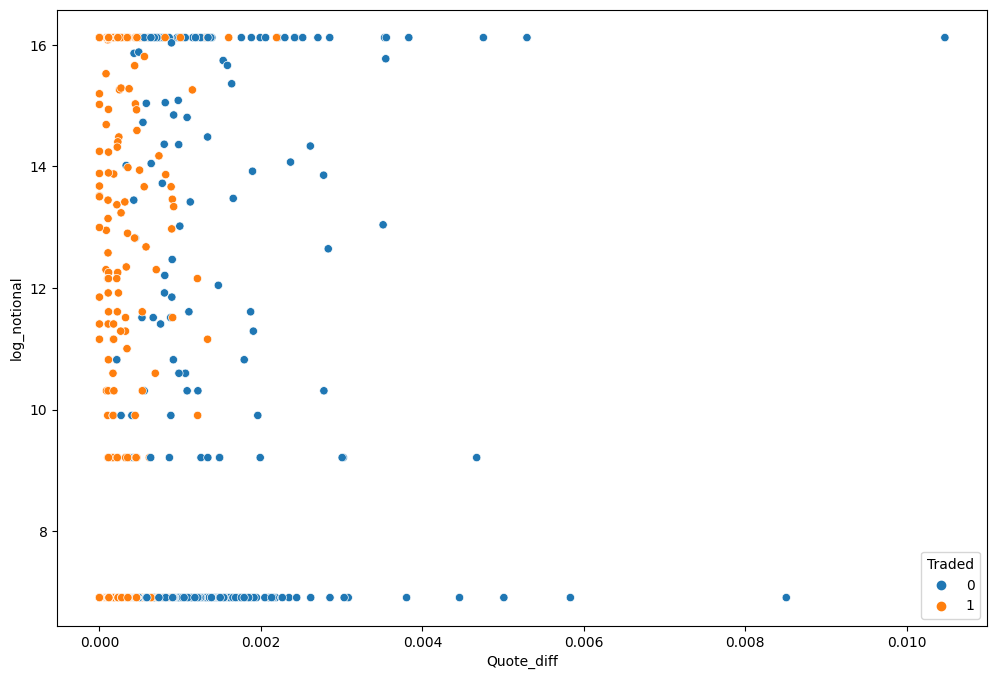

In [61]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Quote_diff',y='log_notional', data=df_analysis[df_analysis['Side'] == 'Offer'], hue='Traded')
plt.show()